# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Manaan | Hamidu | Manaan Hamidu Nov 8 | Hours | 33.3 |
| Member 2: | Regan | Kane | Regan Kane Nov 8 | Hours | 33.3 |
| Member 3: | Kennedy | Connors | Kennedy Connors Nov 8 | 3 | 33.3 |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

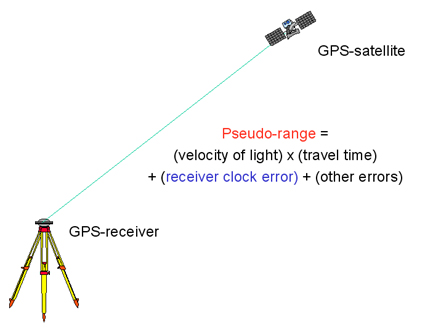

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/

/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3


Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
df_pseudorange = pd.read_excel('pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    #Calculate the geometric distance from receiver to each satellite
    predicted_range = euclidean_norm(r_pos, s_pos) - cdT  # Adding clock offset to each distance

    # Calculate residuals between observed pseudoranges and predicted ranges
    residuals = pseudorange - predicted_range

    # Sum of squared residuals
    L = np.sum(residuals ** 2)/n

    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    # Calculate geometric distance from receiver to each satellite
    predicted_range = euclidean_norm(r_pos, s_pos) - cdT
    residuals = pseudorange - predicted_range

    # Calculate partial derivatives with respect to x_r, y_r, z_r
    dL_dx = np.sum(residuals * (r_pos[0] - s_pos[:, 0]) / predicted_range)
    dL_dy = np.sum(residuals * (r_pos[1] - s_pos[:, 1]) / predicted_range)
    dL_dz = np.sum(residuals * (r_pos[2] - s_pos[:, 2]) / predicted_range)

    # Partial derivative with respect to cdT
    dL_dcdT = np.sum(residuals)

    # Combine gradients into a single array
    grad = np.array([dL_dx, dL_dy, dL_dz, dL_dcdT])
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# print the mentioned metrics
# Print the optimized parameters
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)

# Calculate the final position error of the receiver
final_position_error = optimized_params[:3] - GroundTruth
print("Final Position Errors (x, y, z):", final_position_error)

# Print the number of steps taken for convergence
print("Number of Steps Taken for Convergence:", steps_count)

# Print the final cost value
final_cost_value = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
print("Final Cost Value:", final_cost_value)

# Print the final gradient values
final_gradient_values = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
print("Final Gradient Values:", final_gradient_values)

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248543e+06  6.46899878e+00]
Final Position Errors (x, y, z): [-3.06452905 -2.35814537  3.80784084]
Number of Steps Taken for Convergence: 587
Final Cost Value: 6.1970360980123775
Final Gradient Values: [ 0.00010838  0.00060387 -0.00185594 -0.00105227]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

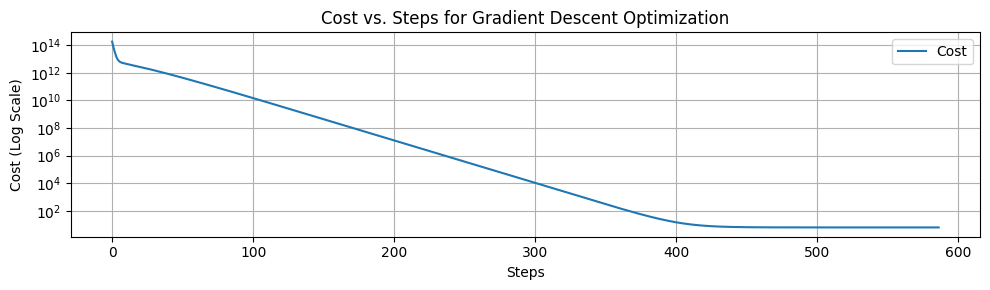

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

# Use 'semilogy' to scale the y-axis
ax.semilogy(arr_cost, label='Cost')

# Label each axis and include figure title
ax.set_xlabel('Steps')
ax.set_ylabel('Cost (Log Scale)')
ax.set_title('Cost vs. Steps for Gradient Descent Optimization')
ax.legend()

# Display grid and show plot
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# As the gradient descent progresses, cost decreases over time, with a steep decline in the initial steps and a gradual approach to a lower bound as it converges.
# The log scale reveals a pattern of diminishing returns, where each additional step results in a smaller reduction in cost, indicating convergence.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

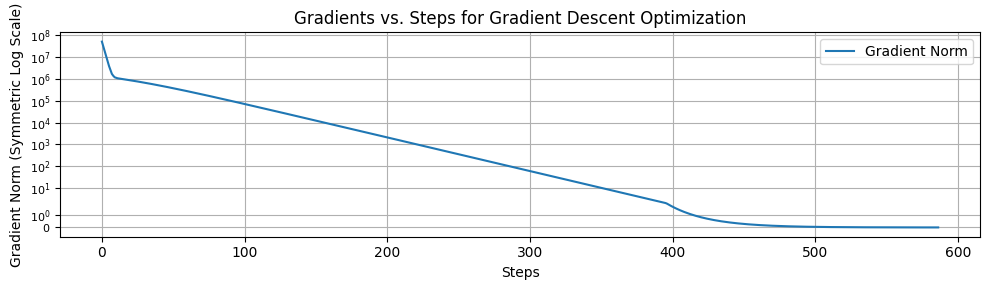

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

# Use 'symlog' to scale the y-axis
ax.plot([np.linalg.norm(g) for g in arr_grad], label='Gradient Norm')
ax.set_yscale('symlog')

# Label each axis, include legend and title
ax.set_xlabel('Steps')
ax.set_ylabel('Gradient Norm (Symmetric Log Scale)')
ax.set_title('Gradients vs. Steps for Gradient Descent Optimization')
ax.legend()

# Set y-axis label size
ax.tick_params(axis='y', labelsize=8)

# Display grid and show plot
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The gradient values decreases as the algorithm converges, indicating that the parameter updates become smaller over time.
# We observed larger gradient values that gradually diminishes, showing that the solution is stabilizing and moving closer to an optimal value.
# This reduction in gradient magnitude indicates that the descent direction is becoming less pronounced as the function approaches a minimum.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

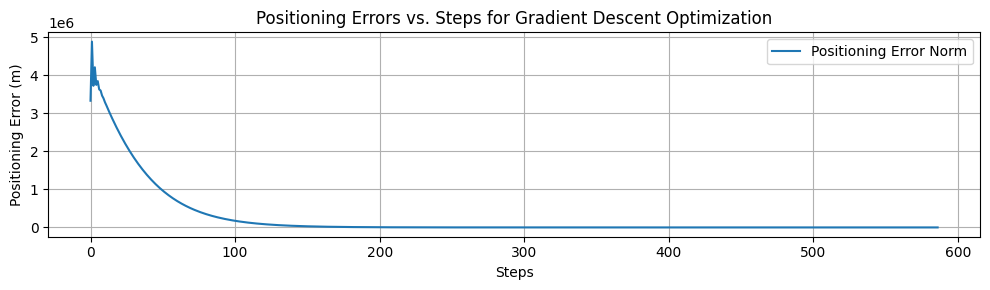

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot the norm of the positioning errors
positioning_errors = [np.linalg.norm(err) for err in arr_err]
ax.plot(positioning_errors, label='Positioning Error Norm')

# Label each axis, include legend and title
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Error (m)')
ax.set_title('Positioning Errors vs. Steps for Gradient Descent Optimization')
ax.legend()

# Display grid and show plot
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# In this plot, the positioning error decreases significantly in the initial steps and gradually stabilize as the algorithm converges.
# The rapid reduction in positioning error early on indicates that the estimated receiver position is quickly approaching the true position.
# As the error decreases and approaches a small value, this signifies that the estimated position is converging close to the actual receiver position, showing the effectiveness of the gradient descent optimization.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

# Call gradient_descent with learning rate 0.01
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=200000)

# Print the metrics for learning rate 0.01
print("\nLearning Rate: 0.01")
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)
final_position_error_2 = optimized_params_2[:3] - GroundTruth
print("Final Position Errors (x, y, z):", final_position_error_2)
print("Number of Steps Taken for Convergence:", steps_count)
final_cost_value_2 = cost_function(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)
print("Final Cost Value:", final_cost_value_2)
final_gradient_values_2 = gradient(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)
print("Final Gradient Values:", final_gradient_values_2)

Converged !

Learning Rate: 0.01
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46237669e+00]
Final Position Errors (x, y, z): [-3.06384697 -2.35434483  3.7961602 ]
Number of Steps Taken for Convergence: 5616
Final Cost Value: 6.197166257357032
Final Gradient Values: [ 0.00034641  0.00193018 -0.00593226 -0.0033632 ]


In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

# Call gradient_descent with learning rate 0.001
optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=300000)

# Print the metrics for learning rate 0.001
print("\nLearning Rate: 0.001")
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_3)
final_position_error_3 = optimized_params_3[:3] - GroundTruth
print("Final Position Errors (x, y, z):", final_position_error_3)
print("Number of Steps Taken for Convergence:", steps_count)
final_cost_value_3 = cost_function(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)
print("Final Cost Value:", final_cost_value_3)
final_gradient_values_3 = gradient(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)
print("Final Gradient Values:", final_gradient_values_3)

Converged !

Learning Rate: 0.001
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162952e+06  4.95248538e+06  6.44143369e+00]
Final Position Errors (x, y, z): [-3.06168983 -2.34232527  3.75921906]
Number of Steps Taken for Convergence: 52935
Final Cost Value: 6.198474640776408
Final Gradient Values: [ 0.00109921  0.00612476 -0.01882393 -0.01067184]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

Q1. Increasing the learning rate accelerates convergence but can risk overshooting the minimum. While reducing the learning rate leads to slower, more controlled convergence, which can increase accuracy if well-tuned.

Q2. Based on our observation LSE is good for simpler, linear problems, as it uses direct analytical methods to find the position which minimizes the residuals in a single calculation. Whilst, Gradient Descent offers more flexibility for complex, non-linear positioning tasks and provides adjustable precision.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [2]:
!pip install ucimlrepo

In [8]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# TO DO: display sizes of X and y (1 mark)
print("Size of X (features):", X.shape)
print("Size of y (target):", y.shape)

Size of X (features): (11055, 30)
Size of y (target): (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

Class distribution:
 result
 1        6157
-1        4898
Name: count, dtype: int64


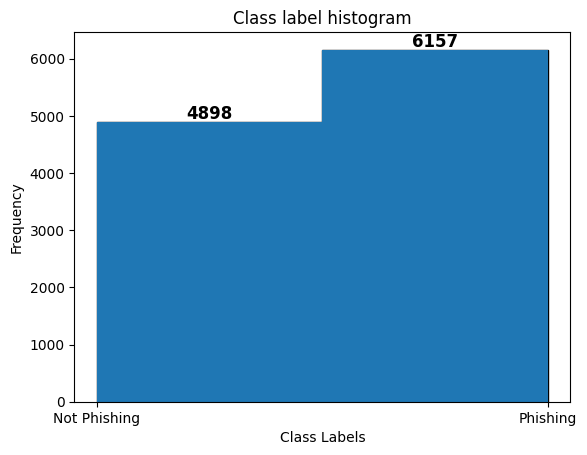

In [34]:
# TO DO: Check the class distribution of y (2 mark)
class_counts = y.value_counts()
print("Class distribution:\n", class_counts)


# Display exact values for each bin in the histogram
plt.figure()
n, bins, patches = plt.hist(y, bins=2, edgecolor='black', color='skyblue')
plt.hist(y, bins=2)
plt.title('Class label histogram')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(ticks=[-1, 1], labels=['Not Phishing', 'Phishing'])
for count, patch in zip(n, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count + 50, f'{int(count)}',
             ha='center', fontsize=12, fontweight='bold')

plt.show()


### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [48]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.97, random_state=42)


# TO DO: display sizes of X_small and y_small (2 mark)
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)


Size of X_small: (331, 30)
Size of y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [51]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)
# Step 3: Import LogisticRegression and necessary modules
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

# Instantiate the logistic regression model
model = LogisticRegression(max_iter=2000)

# Define a function to train, test, and evaluate the model on a given dataset
def evaluate_model(X, y, description="Dataset", random_state=42):
    # Ensure y is one-dimensional
    y = y.values.ravel()

    # Step 4: Split the data (70% train, 30% test) with random_state=42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Calculate training and testing accuracies
    training_accuracy = accuracy_score(y_train, model.predict(X_train))
    testing_accuracy = accuracy_score(y_test, model.predict(X_test))

    # Predict probabilities for log loss calculation
    y_pred_prob = model.predict_proba(X_test)
    log_loss_value = log_loss(y_test, y_pred_prob)

    # Return results in a dictionary format for easy DataFrame conversion
    return {
        "Data size": X.shape[0],
        "Training samples": X_train.shape[0],
        "Testing samples": X_test.shape[0],
        "Training accuracy": training_accuracy,
        "Testing accuracy": testing_accuracy,
        "Log loss": log_loss_value
    }


# Evaluate on the three datasets
# 1. Full dataset (X and y)
results_full = evaluate_model(X, y, description="full dataset (X and y)", random_state=42)

# 2. Only first two columns of X and y
X_first_two = X.iloc[:, :2]  # Select only the first two columns
results_first_two = evaluate_model(X_first_two, y, description="first two columns of X and y", random_state=42)

# 3. Smaller dataset (X_small and y_small)
results_small = evaluate_model(X_small, y_small, description="smaller dataset (X_small and y_small)", random_state=42)

# Step 5.1: Create DataFrame to display results
# Set random_state=0 in any further steps from here onward
results_df = pd.DataFrame([results_full, results_first_two, results_small],
                          index=["Full Dataset", "First Two Columns", "Smaller Dataset"])

# Print results
print(results_df)



                   Data size  Training samples  Testing samples  \
Full Dataset           11055              7738             3317   
First Two Columns      11055              7738             3317   
Smaller Dataset          331               231              100   

                   Training accuracy  Testing accuracy  Log loss  
Full Dataset                0.931119          0.921917  0.187942  
First Two Columns           0.554019          0.577329  0.677354  
Smaller Dataset             0.948052          0.930000  0.192311  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)


### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---